# Project 1: Pose Graph Optimization (scratch + g2o)
TEAM-ID:     
TEAM-NAME:        
YOUR-ID:      
YOUR-NAME:     

(Although you work in groups, both the students have to submit to Moodle, hence there's name field above)

### Submission
Zip a folder of the following:
1. Files that you were provided with: `Project-1.ipynb`, the folders `misc` and `dataset`. Rest of the files asked in the questions below must be generated when i run the code. If generation of any file is computationally intensive, add `filename_backup.extension` where `filename.extension` is the expected name of file when i run the code. (For example, next point.)
2. Add `opt_backup.g2o` (described below) in outermost directory. Here, `opt.g2o` is the expected name of the file when I run the code.
3. For images of any results (like plots), save it in `./misc` folder.

On Moodle, all you have to submit is the jupyter notebook. But make sure to call the necessary functions explicitly (as specified in the notebook). The name of the zipped file being submitted to Moodle Assignment portal MUST BE `ID_Teamname_Firstname`. More details [here](https://www.notion.so/saishubodh/Course-Information-4c9e487b118547b2ba91d24e0dcaf04e#f2707a04f2a0446bac77763b47ba4bac).

On GitHub classrooms, the latest commit before the deadline will be considered as the submission. 

The deadline is Oct 16, 23:55 IST. Please get started ASAP, there is no way you can finish this project during the last few days before the deadline.

### General instructions

This ipython notebook (`.ipynb`) on GitHub is self-sufficient and has all the information you need to get started with the assignment, you don't need any corresponding PDF doc. Just fire up the notebook and get going!

General information like installation instructions in supplementary notebook "Project-1_Code-Walkthrough". Please take a look at it before you start this assignment.

Whenever I mention some `func()` below, I am referring to the "helper functions" in another supplementary notebook "Project-1_Code-Walkthrough" provided to you. Whenever I ask you to insert image below, it is better to save the image in `misc` and load it using `![file_name](file_location)` instead of directly pasting.    

[[CP-]] refers to CheckPoint, you have to ensure you do the tasks at each of the [[CP-]] places below. Not ensuring [[CP-B]] (CheckPoint-Basic) will incur heavy penalty and potentially 0 for that sub-section, and [[CP-M]] (CheckPoint-Marks) has a particular mark weightage depending on your results at that particular CP.

If you face any issues related to coding/installation, please raise an [issue here](https://github.com/Shubodh/MR-project1-pgo/issues). For any conceptual doubts, you can ask on Moodle or Teams as usual.

# 0. Introduction

In this project, we are going to use a non-linear weighted least squares optimization approach to solve the problem of getting a better estimate of our robot's trajectory. Least squares formulations are widely used for optimization, be it computer vision or robotics or machine learning. We will dive deep into it during this project and you will have complete clarity on optimization for vector-valued residual functions. 

In this "Introduction" section, I am going to provide an introduction for SLAM problem for a robot operating in the 2D world. It is 2. section in this Project. The 1D SLAM problem (1.) is far much simpler to understand and will be described directly in the 1. section. 

In a 2D world, a robot has 3 degrees of freedom, i.e. its pose in the world can be expressed by the state vector $\mathbf{x}=(x, y, \theta)^{\mathrm{T}}$. For the scope of this project, we are interested only in the robot's trajectory through the $2 \mathrm{D}$ world, and NOT in distinct landmarks or the surronding map of the environment, i.e. we are only interested in "L"ocalization part of SLAM. 

Therefore, we can represent it as a graph where the vertices represent robot poses $\mathbf{x}_{i}$ and edges represent the spatial constraints between these poses. Such a map is generally called a pose graph.

Two different kinds of constraints are necessary for pose graph SLAM. The first are
odometric constraints that connect two successive states $\mathbf{x}_{i}$ and $\mathbf{x}_{i+1}$ via a motion model. Furthermore, in order to perform loop closing, the robot has to recognize places it already visited before. This place recognition is also a part of the front-end and provides the second type of constraint, the loop closure constraints. These constraints connect two not necessarily successive poses $\mathbf{x}_{i}$ and $\mathbf{x}_{j}$.


![SLAM-trajectory-lc.png](misc/SLAM-trajectory-lc.png)   ![SLAM-trajectory-robust.png](misc/SLAM-trajectory-robust.png) (Source: [Sunderhauf 2012](https://core.ac.uk/download/pdf/89299995.pdf))

You will start from the inaccurate pose graph with odometry and loop closure information and by the end of this Project, you end up with an optimized pose graph (see above images) which should look close to ground truth trajectory. You can watch [this video](https://youtu.be/saVZtgPyyJQ) to get an intuition for what we're about to do.

Okay, that's enough of theory. Let's get out hands dirty with the code!

In [1]:
import matplotlib.pyplot as plt
import math
import os
import jax.numpy as jnp #see supplementary notebook to see how to use this
from jax import jacfwd
import jax

# If you're `importing numpy as np` for debugging purposes, 
# while submitting, please remove 'import numpy' and replace all np's with jnp's.(more in supplementary notebook)

# 1. Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. It has been made [available here](https://www.notion.so/saishubodh/Solved-Example-1D-SLAM-weighted-LS-Illustrating-Sparsity-in-SLAM-d8b45893843b4377b07b1d4aa1aab4de). Your first task is to code this from scratch. [[CP-M]]

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct `jax`'s `jacobian`. Its usage is explained in the supplementary notebook.

In [2]:
##############################################################################
# TODO: Code for Section 1                                                   #

def f(x,u):
    return x+u


u_gt = jnp.array([1,1,1,-3,0])
u_ob = jnp.array([1.1,1.0,1.1,-2.7,0])

x_gt = jnp.array([0,1,2,3,0])
x_ob = jnp.array([0,1.1,2.1,3.2,0.5])

def gn(x_ob,u_ob,max_itr,tol):
    cost_itr=[]
    x_itr=[]
    for itr in range(0,max_itr):
        fx=jnp.append(f(x_ob,u_ob)[:-1],jnp.array([f(x_ob[0],u_ob[-1]),x_ob[0]]))-jnp.append(x_ob[1:],jnp.array([x_ob[-1],0]))
#         print('fx=')
#         print(fx)
        w=jnp.eye(len(x_ob)+1).tolist()
        w[-1][-1]*=10
        w=100*jnp.array(w)
#         print('\nw=')
#         print(w)
        j=jnp.array([[1,-1,0,0,0],
           [0,1,-1,0,0],
           [0,0,1,-1,0],
           [0,0,0,1,-1],
           [1,0,0,0,-1],
           [1,0,0,0,0]])
#         print('\nj=')
#         print(j)
        H=j.T@w@j
#         print('\nH=')
#         print(H)
        b=j.T@w.T@fx
#         print('\nb=')
#         print(b)
        dx=-jnp.linalg.inv(H)@b
#         print('\ndx=')
#         print(dx)
        x_ob+=dx
        print("X",itr+1,"=",x_ob)
        cost_itr.append(0.5*fx.T@w@fx)
        x_itr.append(x_ob)
        if itr!=0:
            if abs(cost_itr[-1]-cost_itr[-2])<tol:
                break
        
    return cost_itr,x_itr

cost,x=gn(x_ob,u_ob,10,10**-6)
print()
print('Final Cost =',cost[-1])
print('Final Pose =',x[-1])

# print(jnp.append(x_ob[1:],jnp.array([x_ob[-1],0])))


##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

/home/shivaansehgal/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


X 1 = [-1.6298145e-09  1.0000000e+00  1.9000000e+00  2.8999999e+00
  9.9999934e-02]
X 2 = [-3.5762282e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  1.0000000e-01]
X 3 = [-3.2782735e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  1.0000000e-01]

Final Cost = 2.5
Final Pose = [-3.2782735e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  1.0000000e-01]


# 2. Pose Graph Optimization for 2D SLAM

Things are about to get interesting!

## 2.1 Coding from scratch

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:
1. Initial position
2. Odometry Contraints/Edges: This "edge" information basically tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges
Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://www.notion.so/saishubodh/G2O-Edge-Description-fa07cc28967541dc8a71170de46c5da7) ).

### Details:
1. Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot [[CP-M]] below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](./misc/robot-poses-MR-P1.png)
(Use `draw()` helper function or `g2o_viewer` or `EVO`)

2. Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using [[CP-M]] frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster.

3. Regarding LM iterations, stopping criterion, information matrix values.

    1. [[CP-B]] As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notion page link)](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).
    
    2. [[CP-B]] You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

    3. [[CP-M]] You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (next section), you will be getting a close to ground truth trajectory.

## 2.1 Answer

Give a detailed answer addressing the above questions. When I run the above code, it should follow points described above (such as plots at every 10 steps) and (When I run the above code, it should) write the optimized poses to a file named `opt.g2o`. As a backup, save another file `opt_backup.g2o` in an offline manner beforehand.

That apart, save important plots and add them here so that it can supplement your answer, for example you could add plots at crucial stages of optimization. You have to add useful metrics/plots from `EVO` (refer to supplementary notebook). Using EVO, the bare minimum you have to report is `mean absolute pose error (ape)` and `mean relative pose error (rpe)`. However, you are encouraged to use tools like `evo_traj` and [more](https://github.com/MichaelGrupp/evo/#command-line-interface) and add more plots/metrics. Marks will be awarded based on overall analysis & presentation which would reflect your understanding.

Note that `EVO` and `g2o_viewer` (below) could help you in debugging.

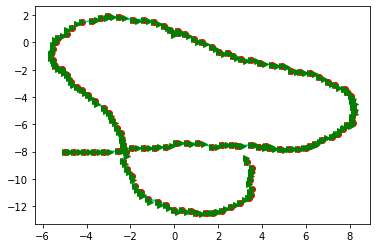

In [3]:
##############################################################################
# TODO: Code for Section 2.1                                                 #
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()
    
    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()

def makeg2o(x, y, z, edgesfile="dataset/edges.txt", g2ofile="file.g2o"):
    f = open(g2ofile, "w")
    for i in range(len(x)):
        f.write("VERTEX_SE2"+" " + str(i) + " " + str(x[i][0]) +" "+ str(y[i][0]) +" "+ str(z[i][0])+"\n")
    
    f2 = open(edgesfile, "r")
    lines = f2.readlines()
    for i in range(1, len(lines)):
        if lines[i][0:3] != "FIX":
            f.write(lines[i])
      
    
v = readVertex('./dataset/edges.txt')
e = readEdge('./dataset/edges.txt')

X = [v[0]]
Y = [v[1]]
THETA = [v[2]]

for it in range(0,len(e[0])):
    i,j,dx,dy,dt = e[0][it],e[1][it],e[2][it],e[3][it],e[4][it]
    if j-i!=1:
        break
    X.append(X[i]+dx*jnp.cos(THETA[i])-dy*jnp.sin(THETA[i]))
    Y.append(Y[i]+dy*jnp.cos(THETA[i])+dx*jnp.sin(THETA[i]))
    THETA.append(THETA[i]+dt)
    
draw(X,Y,THETA)

makeg2o(X,Y,THETA,g2ofile="edges-poses_backup.g2o")
makeg2o(X,Y,THETA,g2ofile="edges-poses.g2o")

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

In [4]:
def fx(x,th,dx,dy):
    dx=jnp.reshape(dx,(-1,1))
    dy=jnp.reshape(dy,(-1,1))
    return x+dx*jnp.cos(th)-dy*jnp.sin(th) 

def fy(y,th,dx,dy):
    dx=jnp.reshape(dx,(-1,1))
    dy=jnp.reshape(dy,(-1,1))
    return y+dy*jnp.cos(th)+dx*jnp.sin(th) 

def fth(th,dt):
    dt=jnp.reshape(dt,(-1,1))
    return th+dt

# def get_f(X,Y,THETA,edges):
def get_f(xx,edges):
    X,Y,THETA=jnp.reshape(xx,(3,len(xx)//3))
    X=jnp.reshape(X,(-1,1))
    Y=jnp.reshape(Y,(-1,1))
    THETA=jnp.reshape(THETA,(-1,1))
    X=jnp.array(X)
    Y=jnp.array(Y)
    THETA=jnp.array(THETA)
    i=edges[0]
    j=edges[1]
    dx=edges[2]
    dy=edges[3]
    dt=edges[4]
    ocl=len(X)
    #odometry constrain
    ocx=fx(X[:-1],THETA[:-1],dx[:ocl-1],dy[:ocl-1])-X[1:]
    ocy=fy(Y[:-1],THETA[:-1],dx[:ocl-1],dy[:ocl-1])-Y[1:]
    octh=fth(THETA[:-1],dt[:ocl-1])-THETA[1:]
    #loop constrain
    ocl-=1
#     print(i[ocl:])
#     iloop=i[ocl:].reshape(-1, 1)
#     jloop=j[ocl:].reshape(1, -1)
    iloop=i[ocl:]
    jloop=j[ocl:]
    lcx=fx(X[iloop],THETA[iloop],dx[ocl:],dy[ocl:])-X[jloop]
    lcy=fy(Y[iloop],THETA[iloop],dx[ocl:],dy[ocl:])-Y[jloop]
    lcth=fth(THETA[iloop],dt[jloop])-THETA[jloop]
    #initial constrains
    icx=X[0]-(-5)
    icy=Y[0]-(-8)
    icth=THETA[0]-(0)
    icx=jnp.reshape(icx,(-1,1))
    icy=jnp.reshape(icy,(-1,1))
    icth=jnp.reshape(icth,(-1,1))
    return jnp.concatenate((ocx,ocy,octh,lcx,lcy,lcth,icx,icy,icth)).reshape(-1)

def getOmega(odo=100.0, loop=500,init=1000 ,odoedges=119, loopedges=20):
    omega = jnp.zeros((odoedges*3 + loopedges*3+3, odoedges*3 + loopedges*3+3))
    for i in range(odoedges*3 + loopedges*3 + 3):
        if i < odoedges*3:
            omega = jax.ops.index_update(omega, jax.ops.index[i, i], odo)
        elif i < odoedges*3 + loopedges*3 :
            omega = jax.ops.index_update(omega, jax.ops.index[i, i], loop)
        else :
            omega = jax.ops.index_update(omega, jax.ops.index[i, i], init)
            
    return omega
    
    
def analitical_jac(THETA,edges):
    i=edges[0]
    j=edges[1]
    dx=edges[2]
    dy=edges[3]
    dt=edges[4]
    ocl=len(THETA)
    iloop=i[ocl-1:]
    jloop=j[ocl-1:]
    jaco=[]
    #X
    for x in range(0,ocl):
        dfx=jnp.zeros(420).tolist()
        if x==0:
            dfx[0]=1
            dfx[-3]=1
        elif x==ocl-1:
            dfx[118]=-1
        else:
            dfx[x]=1
            dfx[x-1]=-1
        for i in range(0,20):
            if iloop[i]==x:
                dfx[357+i]=1
        for j in range(0,20):
            if jloop[j]==x:
                dfx[357+j]=-1
        
        jaco.append(dfx)
        
    #Y
    for y in range(0,ocl):
        dfy=jnp.zeros(420).tolist()
        if y==0:
            dfy[119+0]=1
            dfy[-2]=1
        elif y==ocl-1:
            dfy[237]=-1
        else:
            dfy[119+y]=1
            dfy[119+y-1]=-1
        
        for i in range(0,20):
            if iloop[i]==y:
                dfy[357+20+i]=1
        for j in range(0,20):
            if jloop[j]==y:
                dfy[357+20+j]=-1
        jaco.append(dfy)
        
    #THETA
    for t in range(0,ocl):
        dft=jnp.zeros(420).tolist()
        if t<119:
            dft[t] = (-dx[t]*jnp.sin(THETA[t])-dy[t]*jnp.cos(THETA[t])).tolist()[0]
            dft[119+t] = (-dy[t]*jnp.sin(THETA[t])+dx[t]*jnp.cos(THETA[t])).tolist()[0]
        if t==0:
            dft[238+t]=1
            dft[-1]=1
        elif t==119:
            dft[237+119]=-1
        else:
            dft[238+t]=1
            dft[237+t]=-1
            
        for i in range(0,20):
            if iloop[i]==t:
                dft[357+i] = (-dx[119+i]*jnp.sin(THETA[t])-dy[119+i]*jnp.cos(THETA[t])).tolist()[0]
                dft[357+20+i] = (-dy[119+i]*jnp.sin(THETA[t])+dx[119+i]*jnp.cos(THETA[t])).tolist()[0]
                dft[357+40+i] = 1
        
        for j in range(0,20):
            if jloop[j]==t:
                dft[357+40+j] = -1
        
        jaco.append(dft)
    
    return jnp.array(jaco).T
        
                        
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")        
    
        
def lm(X,Y,THETA,edges,w,lamda=100,max_itr=100,tol=0.001):
    cost_itr=[]
    x_itr=[]
    for it in range(0,max_itr):
#         af=get_f(X,Y,THETA,edges) 
#         ff = lambda X,Y,THETA: get_f(X,Y,THETA,edges)
#         J = jacfwd(ff)
#         j = J(X,Y,THETA)
        #(j'wj + lamda.I)dx = -j'w'f
#         print(X[edges[]])
        xx=jnp.concatenate((X,Y,THETA))
        xx=xx.reshape(-1)
        f=get_f(xx,edges)
        ff = lambda aa : get_f(aa,edges)
        J=jacfwd(ff)
        j=J(xx)
#         w=getOmega()
#         jj=analitical_jac(THETA,edges)
#         frobNorm(j,jj)
        H = j.T@w@j + lamda*jnp.eye(360)
        b = j.T@w.T@f
        dx = -jnp.linalg.inv(H)@b
        dX,dY,dT = jnp.reshape(dx,(3,len(dx)//3))
        X+=dX.reshape((-1,1))
        Y+=dY.reshape((-1,1))
        THETA+=dT.reshape((-1,1))
        cost_itr.append(0.5*f.T@w@f)
        print("err",it+1,"=",cost_itr[-1])
        x_itr.append([X,Y,THETA])
#         draw(X,Y,THETA)
        if it!=0:
            if cost_itr[-1]>cost_itr[-2]:
                lamda/=10
            else:
                lamda*=10
            if abs(cost_itr[-1]-cost_itr[-2])<tol:
                break
    return cost_itr,x_itr

w=getOmega(1,10,10)
cost,x=lm(jnp.array(X),jnp.array(Y),jnp.array(THETA),e,w,lamda=0.1) 
print("YAAAAA")

err 1 = 9062.136
err 2 = 1621.8372
err 3 = 32.34127
err 4 = 27.85594
err 5 = 27.586254
err 6 = 27.55982
err 7 = 27.55718
err 8 = 27.556923
YAAAAA


Iteration= 1  Cost= 9062.136


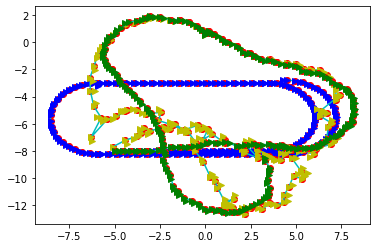

Iteration= 2  Cost= 1621.8372


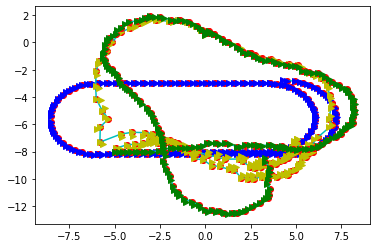

Iteration= 3  Cost= 32.34127


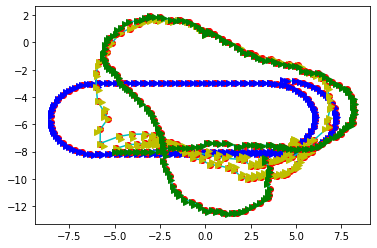

Iteration= 4  Cost= 27.85594


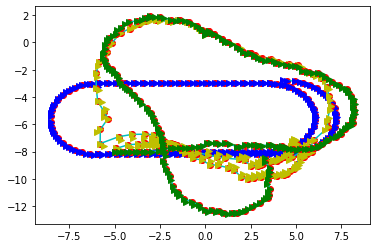

Iteration= 5  Cost= 27.586254


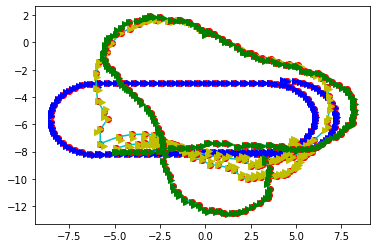

Iteration= 6  Cost= 27.55982


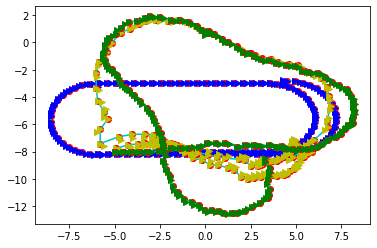

Iteration= 7  Cost= 27.55718


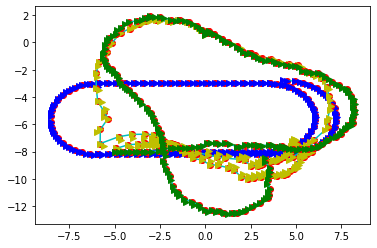

Iteration= 8  Cost= 27.556923


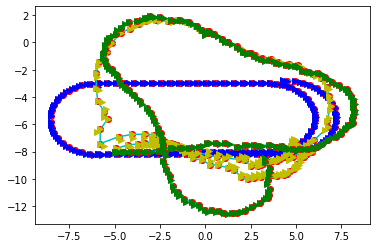

In [5]:
def draw2(Xn, Yn, THETAn):  
    ax = plt.subplot()

    # Ground Truth
    Xgt, Ygt, THETAgt=v_gt[0],v_gt[1],v_gt[2]
    ax.plot(Xgt, Ygt, 'ro')
    plt.plot(Xgt, Ygt, 'c-')

    for i in range(len(THETAgt)):
        x2 = 0.25*math.cos(THETAgt[i]) + Xgt[i]
        y2 = 0.25*math.sin(THETAgt[i]) + Ygt[i]
        plt.plot([Xgt[i], x2], [Ygt[i], y2], 'b->')
    
    #Cont.
    ax.plot(Xn, Yn, 'ro')
    plt.plot(Xn, Yn, 'c-')

    for i in range(len(THETAn)):
        x2 = 0.25*math.cos(THETAn[i]) + Xn[i]
        y2 = 0.25*math.sin(THETAn[i]) + Yn[i]
        plt.plot([Xn[i], x2], [Yn[i], y2], 'y->')

    
    #Noizy
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()
    
v_gt = readVertex('./dataset/gt.txt')
# e_gt = readEdge('./dataset/gt.txt')

for i in range(0,len(x)):
    print("Iteration=",i+1," Cost=",cost[i])
    Xn,Yn,THETAn=x[i][0],x[i][1],x[i][2]
    draw2(Xn,Yn,THETAn)

In [6]:

'''
var=[1,5,10,50,100,1000,10000]

for od in var:
    for lp in var:
        for init in var:
#             print(od,lp,init)
            w=getOmega(od,lp,init)
            for lam in [0.01,0.1,1,10,100,1000]:
#                 print(lamda)
                cost,x=lm(jnp.array(X),jnp.array(Y),jnp.array(THETA),e,w,lamda=lam)
                num_itr=len(cost)
                final_cost=cost[-1]
                Xn,Yn,THETAn = x[-1]
                ##### Save #####
                ax = plt.subplot(111)
                ax.plot(Xn, Yn, 'ro')
                plt.plot(Xn, Yn, 'c-')

                for i in range(len(THETAn)):
                    x2 = 0.25*math.cos(THETAn[i]) + Xn[i]
                    y2 = 0.25*math.sin(THETAn[i]) + Yn[i]
                    plt.plot([Xn[i], x2], [Yn[i], y2], 'g->')
                print(str(final_cost)+'-'+str(num_itr)+'-'+str(od)+'-'+str(lp)+'-'+str(init)+'-'+str(lam)+'.png')
                plt.savefig('./new_output/'+str(int(final_cost))+'-'+str(num_itr)+'-'+str(od)+'-'+str(lp)+'-'+str(init)+'-'+str(lam)+'.png')
                plt.clf()
'''


"\nvar=[1,5,10,50,100,1000,10000]\n\nfor od in var:\n    for lp in var:\n        for init in var:\n#             print(od,lp,init)\n            w=getOmega(od,lp,init)\n            for lam in [0.01,0.1,1,10,100,1000]:\n#                 print(lamda)\n                cost,x=lm(jnp.array(X),jnp.array(Y),jnp.array(THETA),e,w,lamda=lam)\n                num_itr=len(cost)\n                final_cost=cost[-1]\n                Xn,Yn,THETAn = x[-1]\n                ##### Save #####\n                ax = plt.subplot(111)\n                ax.plot(Xn, Yn, 'ro')\n                plt.plot(Xn, Yn, 'c-')\n\n                for i in range(len(THETAn)):\n                    x2 = 0.25*math.cos(THETAn[i]) + Xn[i]\n                    y2 = 0.25*math.sin(THETAn[i]) + Yn[i]\n                    plt.plot([Xn[i], x2], [Yn[i], y2], 'g->')\n                print(str(final_cost)+'-'+str(num_itr)+'-'+str(od)+'-'+str(lp)+'-'+str(init)+'-'+str(lam)+'.png')\n                plt.savefig('./new_output/'+str(int(final_c

## Explain your experimentation in detail using tables/plots etc if necessary.

We have looped over various parameters. Mainly for 𝛀 constrains and Lamda. As shown in above block.  

The deciding factor was error and shape(Mainly a single and perfect loop because we were only sure about loop closers). We have shown some of the expriment results below.

| Sno. | Edge | Loop | Fix | Lamda | Error | Num Itr. | Result
| - | - | - |- | - | - |- | - |
| 1 | 1 | 1 | 1 | 0.01 | 9 | 8 | ![title](./misc/Results/9-8-1-1-1-0.01.png) |
| 2 | 1 | 1000 | 50 | 0.01 | 25 | 9 | ![title](./misc/Results/25-9-1-1000-50-0.01.png) |
| 3 | 1 | 10 | 10 | 0.1 | 27 | 8 | ![title](./misc/Results/27-8-1-10-10-0.1.png) |
| 4 | 5 | 1 | 1 | 1 | 202 | 8 | ![title](./misc/Results/202-8-5-1-1-1.png) |
| 5 | 1 | 100 | 1000 | 100 | 2676 | 10 | ![title](./misc/Results/2676-10-1-100-10000-100.png) |



In [7]:
makeg2o(x,Y,THETA,g2ofile="opt_backup.g2o")
makeg2o(X,Y,THETA,g2ofile="opt.g2o")

Add answer for 2.1 here:

## 2.2 Using g2o's optimization: g2o binary or g2o viewer 

Installation setup is described in supplementary notebook. More details for 2.2.1 and 2.2.2 can be found in the supplementary notebook.

### 2.2.1 Optimizing `edges.txt`
First task is to optimize the poses of dataset you've been working with so far.

### 2.2.2 Optimizing `intel` and `sphere` datasets
You have been given two datasets in the `data` folder. You have to use `g2o_viewer` to optimize these both. You have to experiment with the options/parameters available in the GUI. More instructions in supplementary notebook. You have to experiment till you get the trajectories which look like the following:

<table><tr>
<td> <img src="./misc/intel.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./misc/sphere.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

## 2.2 Answer

Add images: take screenshot of the GUI of `g2o_viewer` after optimization for all 3 [[CP-M]] and add here. Briefly describe what you had to do (detailed answer is not expected). g2o could potentially give you close to ground truth trajectory for all 3, but if you are unable to get to close to ground truth, add the best you can get.

###  * Important Information regarding Questions 3  & 4
Note that it is mandatory to attempt EITHER 3 OR 4, only one of it. If you attempt both, the question which you score more will be considered and the other as bonus question. 

It is encouraged for those into robotics/deep learning research to prefer 4 over 3.

# [Bonus*] 3. Deriving Motion model geometrically
\* -> read information above under section "Important Information regarding Questions 3  & 4"

 
The current robot state is as follows: ($i$ and $k$ are interchangably used below, sorry I am too lazy to edit now 😛)  
![robot-situation.png](./misc/robot-situation.png)

Can you derive the below equation using geometry? (Read on)

$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

In other words, we want to find $\delta$'s in terms of $\Delta$'s
$$\delta x = \Delta x \cos(\theta) - \Delta y \sin(\theta) \\
\delta y = \Delta y \cos(\theta) + \Delta x \sin(\theta) \tag{2}$$

where $\delta$'s are the updates in our motion model equation:
$$ x_{k+1} = x_{k} + \delta x \\
y_{k + 1} = y_k + \delta y \\
\theta_{k+1} = \theta_{k} + \delta \theta \tag{1}$$

Oh yes, $\theta$ is straightforward, i.e. $\delta \theta = \Delta \theta$ but why? 

Using geometry, you could just draw and insert a self-explanatory image as the answer to this question.

If you can derive it without using geometry purely using transform matrices/algebra, that is fine too. Whatever you're comfortable.

## 3. Answer


Your answer here.

# [Bonus*] 4. Research Paper Reading
\* -> read information above under section "Important Information regarding Questions 3  & 4"

(Do not get intimidated, you are not expected to do a thorough research analysis for this task. A high level understanding is sufficient.)


["Past, Present & Future of SLAM: Towards the Robust Perception Age"](https://arxiv.org/abs/1606.05830) is an exciting survey paper of 2016 which sums up, well, the "past, present & future" of SLAM. Your task is as follows:

1. Go through the sections "IV. LONG-TERM AUTONOMY II: SCALABILITY" & "III. LONG-TERM AUTONOMY I: ROBUSTNESS". Don't worry, you are not expected to have a deep understanding. Skip the parts which you don't understand at all. Go through it at a high level, and take a slightly closer look at "Open Problems" in these sections.

2. Read up common applications of deep learning for computer vision/robotics through blogs online (for example, first 4 points of [this](https://machinelearningmastery.com/applications-of-deep-learning-for-computer-vision/). Again, you are only expected to understand it at a high level, for example, 'semantic segmentation is an application of deep learning for computer vision which is the task of assigning a category to each of the pixels in the image'.

Firstly, summarize your understanding of the above two points.
   
Now, from the understanding you've gathered so far, how would you approach solving those "Open Problems"? 
Can these algorithms help in dealing with some of the issues you might have faced during this project? Can the deep learing based high level understanding of the world help in SLAM? In the context of long term autonomy, imagine tomorrow's world with a buddy robot R2-D2 which follows you wherever you go... Now imagine how easily the trajectory can diverge, how big the map could soon become and how the computation could easily become intractable.   

Answer the above questions in the context of this project and those 2 sections of the survey paper.

## 4. Answer


Your answer here.

### Fun section
Check the end of your Project-1 homepage on Notion. :)